In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create an inspector object to explore the database
inspector = inspect(engine)

# Reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


C:\Users\mitch\AppData\Local\Temp\ipykernel_24280\2338356467.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
# Print the classes found by automap
print("Classes found by automap:")
print(Base.classes.keys())

Classes found by automap:
['station', 'measurement']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


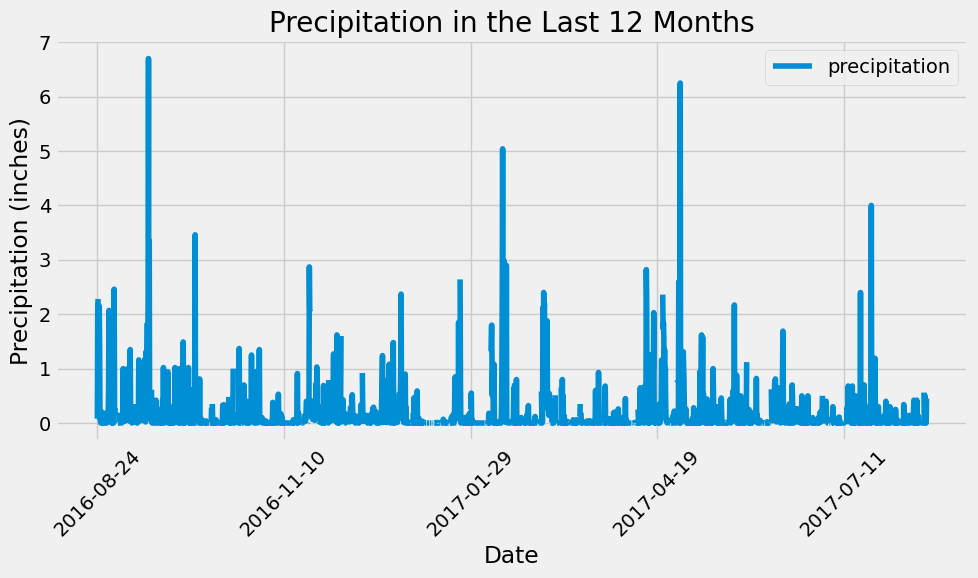

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= one_year_ago).\
          order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(10, 6), title='Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()

print("Summary Statistics for Precipitation Data:")
summary_statistics

Summary Statistics for Precipitation Data:


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations in the dataset: {total_stations}")



Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Number of Rows: {count}")

Most Active Stations:
Station: USC00519281, Number of Rows: 2772
Station: USC00519397, Number of Rows: 2724
Station: USC00513117, Number of Rows: 2709
Station: USC00519523, Number of Rows: 2669
Station: USC00516128, Number of Rows: 2612
Station: USC00514830, Number of Rows: 2202
Station: USC00511918, Number of Rows: 1979
Station: USC00517948, Number of Rows: 1372
Station: USC00518838, Number of Rows: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()

print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


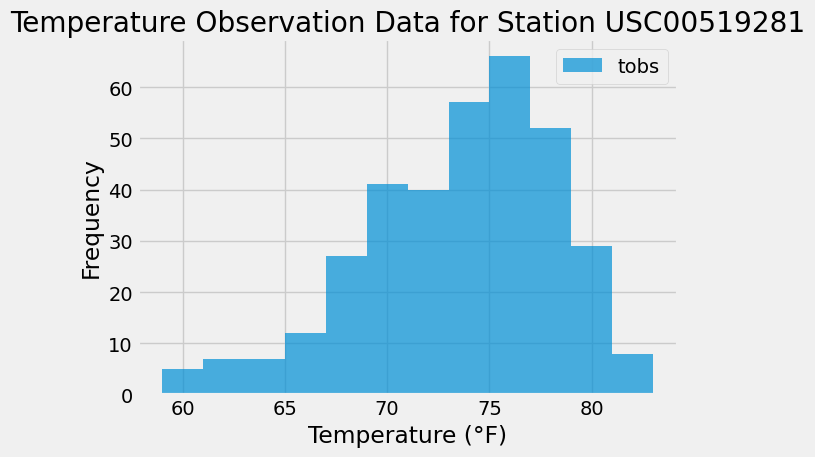

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs', alpha=0.7)
plt.title(f"Temperature Observation Data for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()